# Mapeo pro-bono: Prototipo 1
## Importar dependencias

In [44]:
import pandas as pd
import geopandas as gpd
import re
import math

## Importar regiones geograficas

In [69]:
region_dataframes = [
    gpd.read_file('../regions/Apodaca/AgebsDentrodeApodaca.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Escobedo/AgebsDentrodeEscobedo.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Garcia/AgebsDentrodeGarcia.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Juarez/AgebsDentrodeJuarez.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Monterrey/AgebsDentrodeMonterrey.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/San Nicolas/AgebsDentroSanNicolas.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/San Pedro/AgebsDentrodeSanPedro.shp').to_crs('WGS 84'),
    gpd.read_file('../regions/Santa Catarina/AgebsDentrodeSantaCatarina.shp').to_crs('WGS 84')
]

for region in region_dataframes:
    region.rename(columns={'Nombre': 'sector_name'}, inplace=True)

guadalupe = gpd.read_file('../regions/Guadalupe/Copia de GUADALUPESectores.shp').to_crs('WGS 84')
guadalupe.rename(columns={'Name': 'sector_name'}, inplace=True)
region_dataframes.append(guadalupe)


regions = gpd.GeoDataFrame(pd.concat(region_dataframes, ignore_index=True))
regions.set_index('sector_name', inplace=True)

<Axes: >

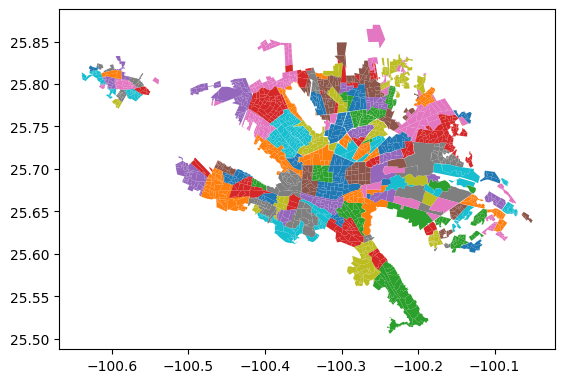

In [65]:
regions.plot("sector_name")

## Cargar datos del formulario

In [70]:
survey_answers = pd.read_csv('../respuestas_formulario.csv')

municipios = [
    'Apodaca',
    'Escobedo',
    'Garcia',
    'Guadalupe',
    'Juarez',
    'Monterrey',
    'San Nicolás de los Garza',
    'Santa Catarina',
    'San Pedro Garza García',
    'Agualeguas',
    'Allende',
    'Anahuac',
    'Aramberri',
    'Bustamante',
    'General Bravo',
    'Cerralvo',
    'Cienega',
    'China',
    'Dr Arroyo',
    'Dr. Coss',
    'Dr. Gonzalez',
    'El Carmen',
    'Abasolo',
    'Villaldama',
    'Hidalgo',
    'Gral Zuazua',
    'Gral. Zaragoza',
    'Gral Treviño',
    'Gral Terán',
    'Valecillo',
    'Santiago',
    'Salinas Victoria',
    'Sabinas Hidalgo',
    'Rayones',
    'Pesquería',
    'Parás',
    'Montemorelos',
    'Mina',
    'Mier y Noriega',
    'Melchor Ocampo',
    'Marín',
    'Los Ramones',
    'Las Herreras',
    'Los Aldamas',
    'Linares',
    'Lampazos',
    'Iturbide',
    'Hualahuises',
    'Galeana',
    'Cadereyta',
]

column_regex = re.compile(r'^.*\((.*)\)$')


def municipio_filter(column: str):
    match = column_regex.match(column)
    if match is not None:
        return match.group(1) in municipios
    else:
        return False


filtered_columns = list(filter(
    municipio_filter,
    survey_answers.columns))

organization_with_regions = survey_answers.filter(items=filtered_columns)

data = {'organization': [], 'sector_name': []}

for index, row in organization_with_regions.iterrows():
    organization = survey_answers['1. Nombre de la organización/colectivo/iniciativa:'][index]
    for value in row:
        if isinstance(value, str):
            sectors = value.split(',')
            for sector in sectors:
                data['organization'].append(organization)
                data['sector_name'].append(sector)

organization_region_names = pd.DataFrame(data=data)
organization_region_names


,organization,sector_name
0,geostats,Ebanos
1,geostats,Huinalá
2,geostats,Jardines de Primavera
3,geostats,Las Palmas
4,geostats,Mezquital
5,geostats,Sendero
6,geostats,Miravista
7,geostats,Acueducto
8,geostats,Oriente
9,NaN,Mezquital


<Axes: >

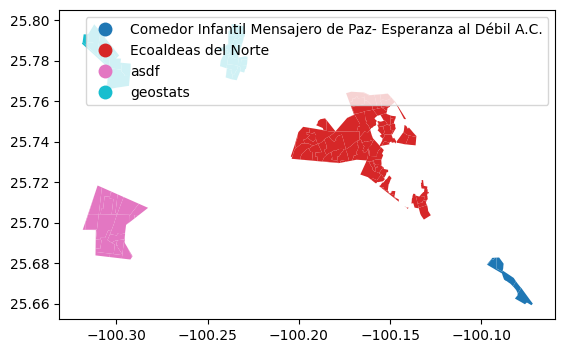

In [74]:
organization_regions = gpd.GeoDataFrame(organization_region_names.join(regions, on='sector_name', how='left'))
organization_regions.plot('organization', legend=True)